



<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [124]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [125]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

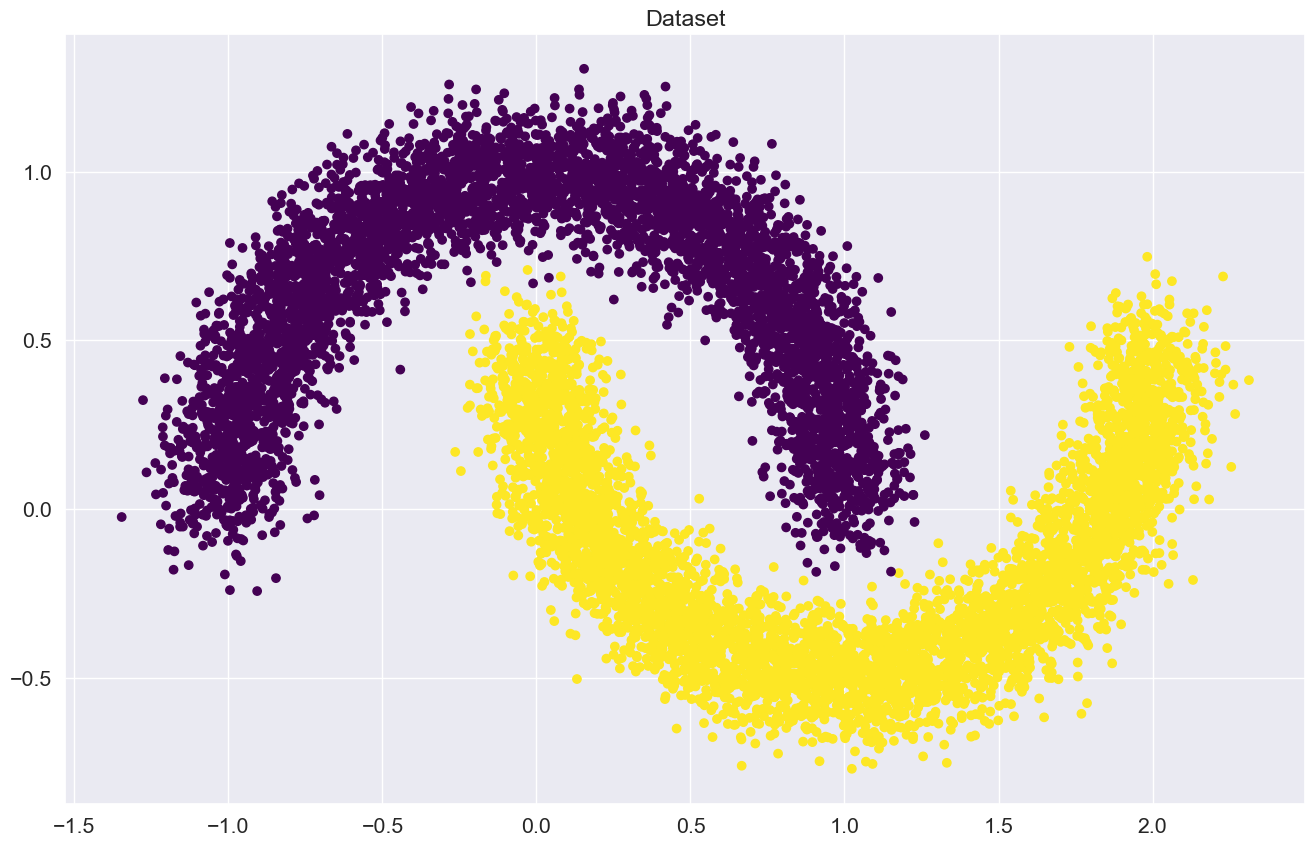

In [126]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [127]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [128]:
X_train_t =  torch.as_tensor(X_train, dtype = torch.float32)
y_train_t =  torch.as_tensor(y_train, dtype = torch.float32)
X_val_t =    torch.as_tensor(X_val, dtype = torch.float32)
y_val_t =    torch.as_tensor(y_val, dtype = torch.float32)

In [129]:
X_train_t.type()

'torch.FloatTensor'

Создаем `Dataset` и `DataLoader`. 

In [130]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession


$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [131]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features))     # веса инициализированы 
        self.bias = bias
        if bias:
            self.bias_term = torch.nn.Parameter(torch.Tensor(out_features))     # генерируем вектор смещения

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x +=  self.bias
        return x
    


In [132]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [133]:
from torchinfo import summary

summary(linear_regression, (1, 2))

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Train loop


### Задание. Реализация цикла обучения

In [134]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        
        optimizer.zero_grad()

        outp =  linear_regression.forward(X_batch)
        loss =  loss_function(outp.view(-1), y_batch)
        

        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        
        probabilities = torch.exp(outp) / torch.exp(outp).sum(dim=1, keepdims=True)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        
        current_weights = linear_regression.weights.detach().clone()
        
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
       
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.484375
Iteration: 100
Batch accuracy: 0.546875
Iteration: 200
Batch accuracy: 0.4609375
Iteration: 300
Batch accuracy: 0.578125
Iteration: 400
Batch accuracy: 0.4765625
Iteration: 500
Batch accuracy: 0.4921875
Iteration: 600
Batch accuracy: 0.40625
Iteration: 700
Batch accuracy: 0.515625
Iteration: 800
Batch accuracy: 0.53125

Iteration: 873.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 873

### Визуализируем результаты

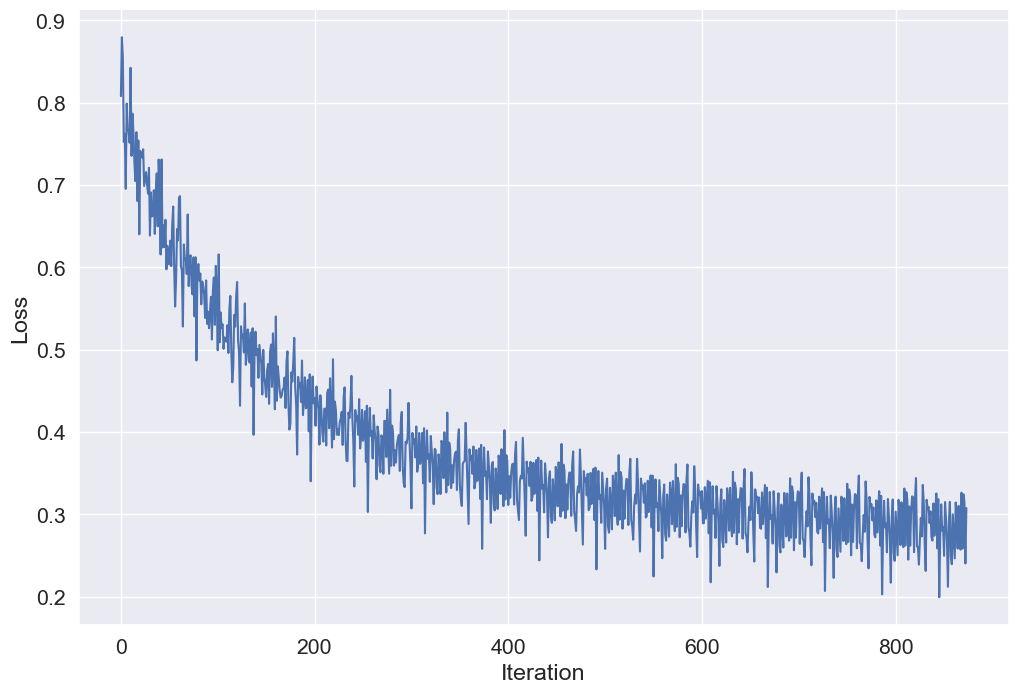

In [135]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

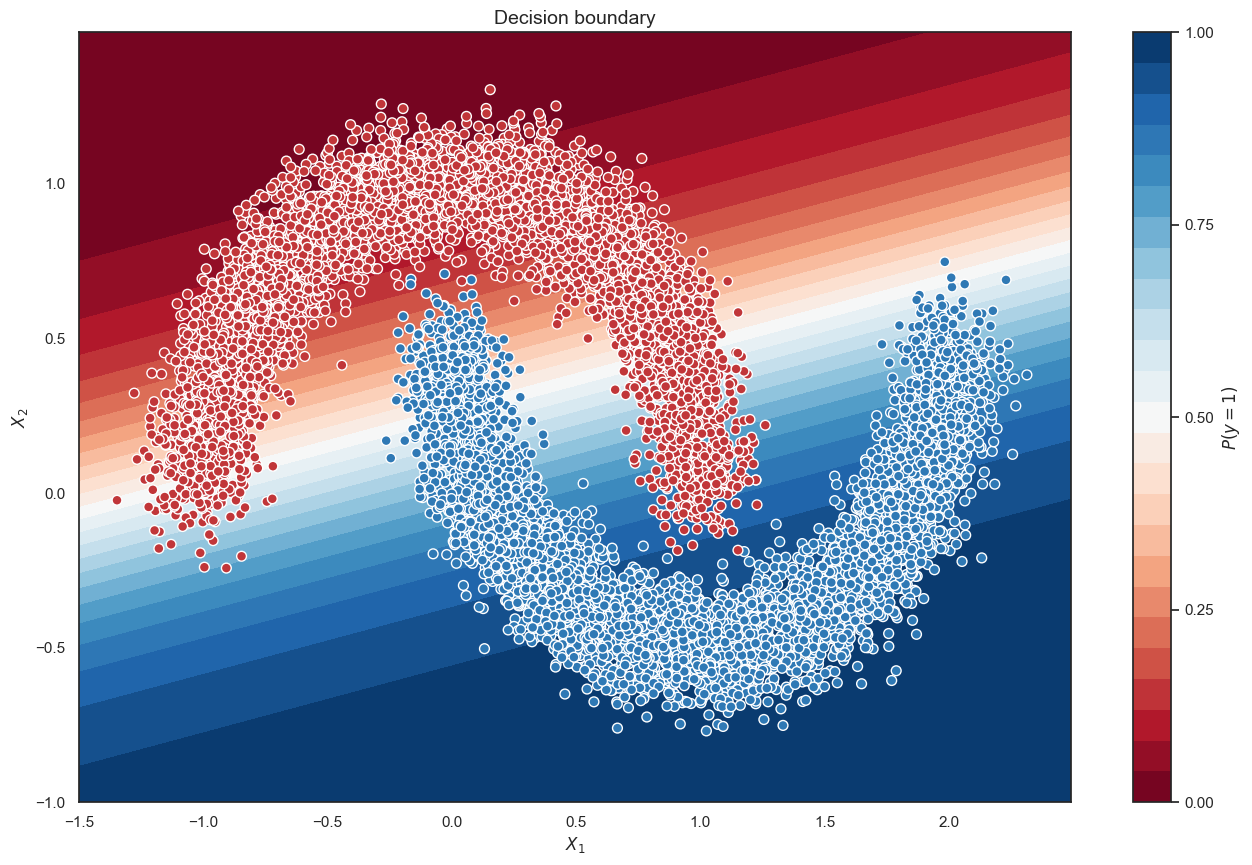

In [136]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [161]:
@torch.no_grad()
def predict(dataloader, model):
    
    model.eval()
    predictions = np.array([])
    
    for x_batch, _ in dataloader:
        preds = torch.sigmoid(linear_regression(x_batch)) > 0.5
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    
    return predictions.flatten()

In [162]:
from sklearn.metrics import accuracy_score

pred = predict(val_dataloader, linear_regression)
accuracy_score(y_val, pred)

0.8852

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**  0.8852

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [169]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)

valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                          shuffle=True, num_workers=2)

In [177]:
print(f"Train size {train_dataloader.dataset.train_data.shape}")
print(f"Valid size {valid_dataloader.dataset.test_data.shape}")

Train size torch.Size([60000, 28, 28])
Valid size torch.Size([10000, 28, 28])


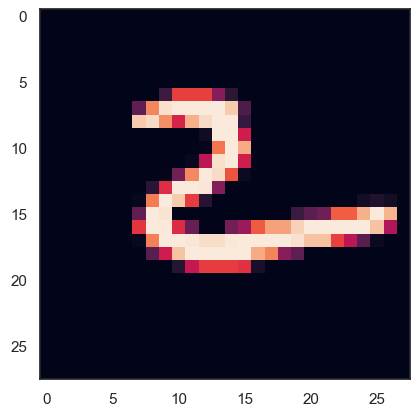

In [184]:
numpy_img = train_dataloader.dataset.train_data[109].numpy()
plt.imshow(numpy_img);

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [178]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [244]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 10),

    # nn.Softmax()        не нужен так как наши функции потерь умеют работать с логитами
)

In [245]:
criterion = nn.CrossEntropyLoss()  # (logsoftmax + negative likelihood) в своей основе применительно к логитам (logits)
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [246]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


### Задание. Дополните цикл обучения.

In [247]:
for k, dataloader in loaders.items():
    print(k)

train
valid


In [248]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad() #обнуляем градиенты 
                outp = model(x_batch.to(device))
                     
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
        
            preds = outp.argmax(-1)

            # считаем число правильных ответов 
            correct =  preds[(preds==y_batch)].shape[0] # берем колличество корректных ответов
            all =  preds.shape[0]
            epoch_correct += correct
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                # Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.90995
Loader: valid. Accuracy: 0.9461
Epoch: 2
Loader: train. Accuracy: 0.9488166666666666
Loader: valid. Accuracy: 0.9532
Epoch: 3
Loader: train. Accuracy: 0.9564
Loader: valid. Accuracy: 0.9586
Epoch: 4
Loader: train. Accuracy: 0.96275
Loader: valid. Accuracy: 0.964
Epoch: 5
Loader: train. Accuracy: 0.9653166666666667
Loader: valid. Accuracy: 0.9587
Epoch: 6
Loader: train. Accuracy: 0.9668833333333333
Loader: valid. Accuracy: 0.9468
Epoch: 7
Loader: train. Accuracy: 0.96985
Loader: valid. Accuracy: 0.9496
Epoch: 8
Loader: train. Accuracy: 0.9718833333333333
Loader: valid. Accuracy: 0.9648
Epoch: 9
Loader: train. Accuracy: 0.9728333333333333
Loader: valid. Accuracy: 0.9611
Epoch: 10
Loader: train. Accuracy: 0.9743166666666667
Loader: valid. Accuracy: 0.9624


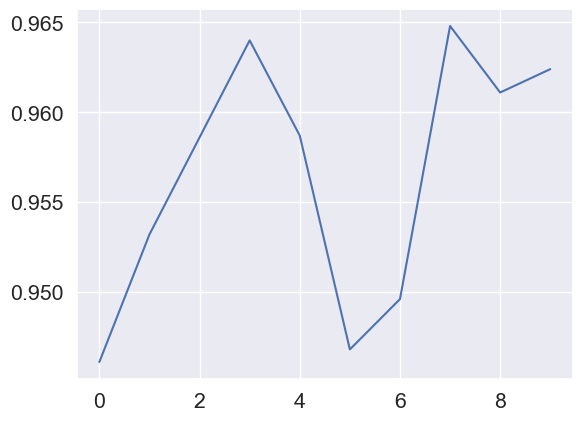

In [250]:
plt.plot(accuracy["valid"])

### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [251]:
elu_accuracy = accuracy["valid"]

In [260]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 10)
    )

    criterion = nn.CrossEntropyLoss()  # (logsoftmax + negative likelihood) в своей основе применительно к логитам (logits)
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad() #обнуляем градиенты 
                    outp = model(x_batch.to(device))
                     
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
        
                preds = outp.argmax(-1)

                # считаем число правильных ответов 
                correct =  preds[(preds==y_batch)].shape[0] # берем колличество корректных ответов
                all =  preds.shape[0]
                epoch_correct += correct
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    # Calculate gradients and make a step of your optimizer
                    loss.backward()
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy['valid']


In [261]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8578
Loader: valid. Accuracy: 0.8951
Epoch: 2
Loader: train. Accuracy: 0.8837166666666667
Loader: valid. Accuracy: 0.8945
Epoch: 3
Loader: train. Accuracy: 0.8912833333333333
Loader: valid. Accuracy: 0.9038
Epoch: 4
Loader: train. Accuracy: 0.8938833333333334
Loader: valid. Accuracy: 0.8836
Epoch: 5
Loader: train. Accuracy: 0.8971166666666667
Loader: valid. Accuracy: 0.8977
Epoch: 6
Loader: train. Accuracy: 0.8972833333333333
Loader: valid. Accuracy: 0.8953
Epoch: 7
Loader: train. Accuracy: 0.8960333333333333
Loader: valid. Accuracy: 0.9035
Epoch: 8
Loader: train. Accuracy: 0.8996333333333333
Loader: valid. Accuracy: 0.901
Epoch: 9
Loader: train. Accuracy: 0.90075
Loader: valid. Accuracy: 0.8378
Epoch: 10
Loader: train. Accuracy: 0.9017166666666667
Loader: valid. Accuracy: 0.8877
Epoch: 1
Loader: train. Accuracy: 0.9016333333333333
Loader: valid. Accuracy: 0.9399
Epoch: 2
Loader: train. Accuracy: 0.9393333333333334
Loader: valid. Accuracy: 0.9451
Epo

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

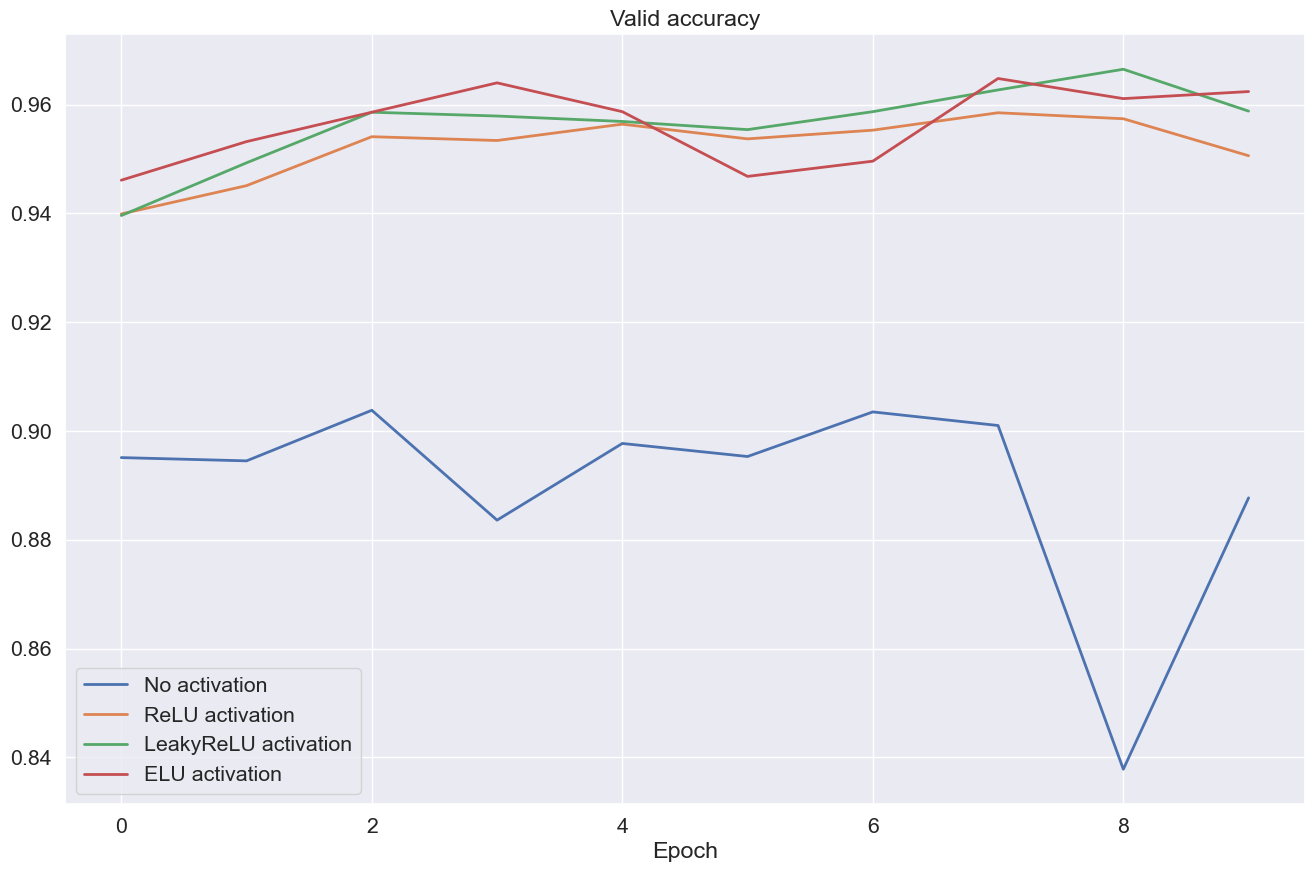

In [262]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

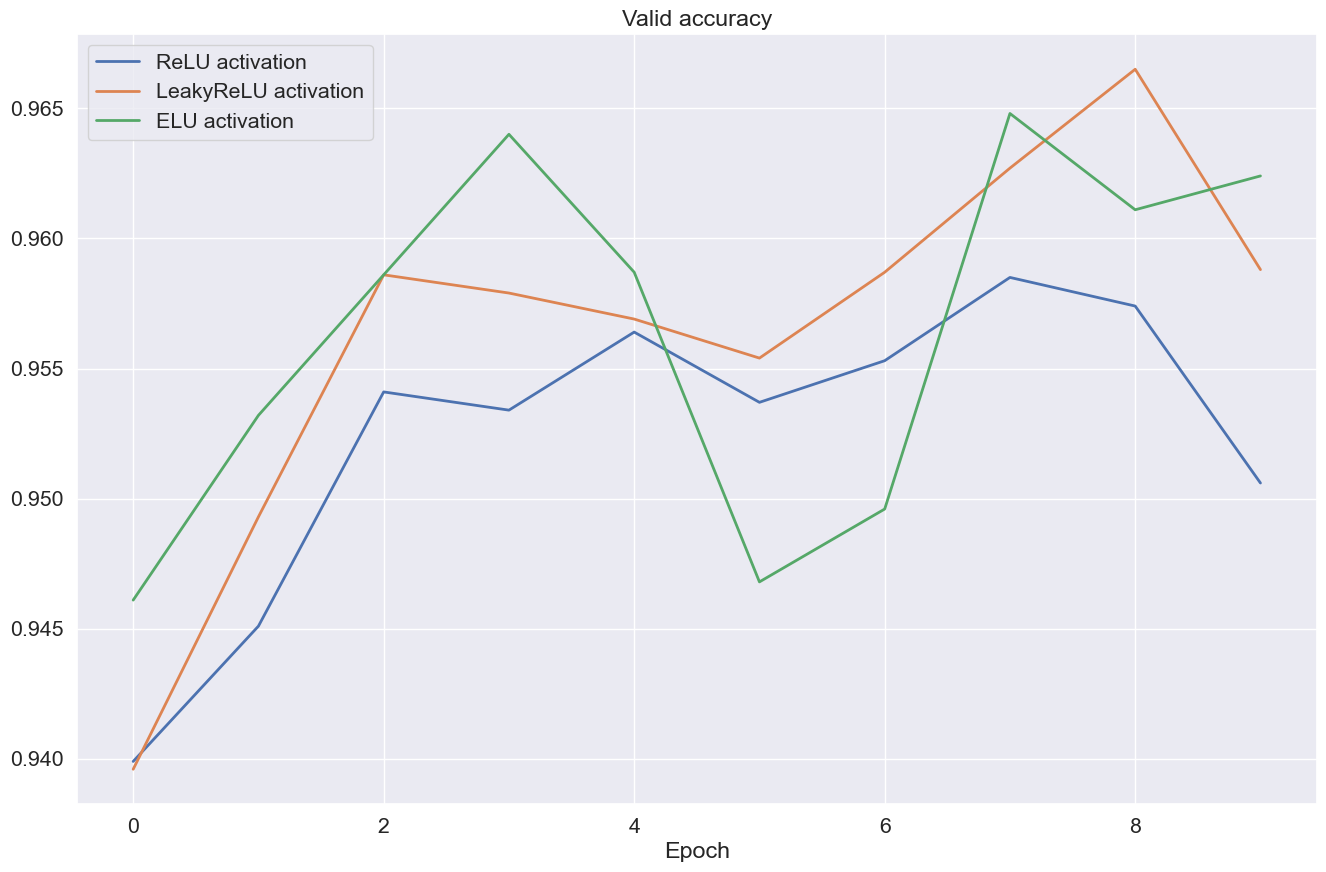

In [263]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [264]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-01 19:02:14--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-01 19:02:14--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: 'sample_photo.jpg'

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.07s   

2023-04-01 19:02:15 (706 KB/s) - 'sample_photo.jpg' sa

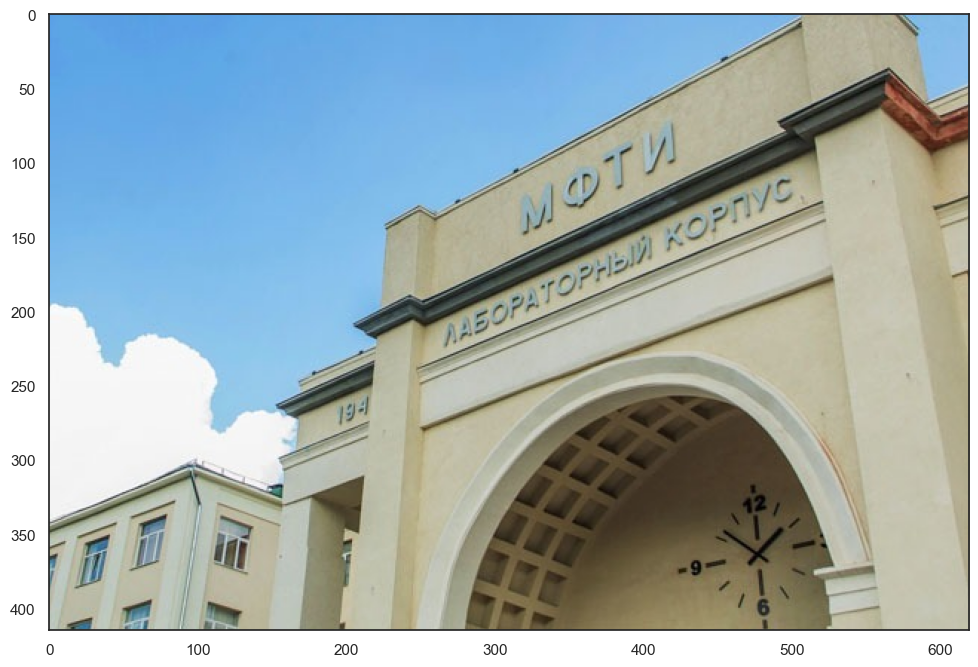

In [268]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [348]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
 [0, 1, 0],
[1, -1, 1],
[0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)
kernel = kernel.repeat(3, 3, 1, 1)

img_t = img_t.permute(0, 3, 1, 2)     # [BS, H, W, C] -> [BS, C, H, W] #[размер батча, каналов, высота, ширина]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

torch.Size([1, 1, 3, 3])
torch.Size([3, 3, 3, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


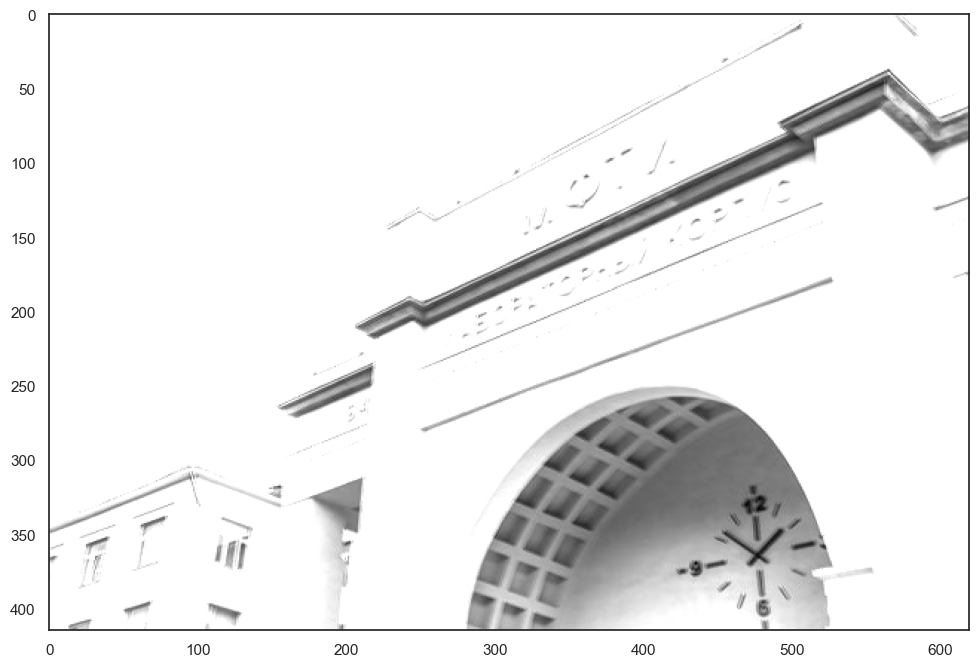

In [349]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие Е

2) Увеличение резкости Д

3) Тождественное преобразование А

4) Выделение вертикальных границ В

5) Выделение горизонтальных границ - Б

6) Выделение границ - Г

**Ответ:** А-3, Б-5, В-4, Г-6, Д-2, Е-1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [388]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.flatten = nn.Flatten()

        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.fc1 = nn.Linear(16*22*22, 120)      # x - torch.Size([4, 16, 22, 22]) размер батча - 4, выход 16, 22, 22
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = self.flatten(x)         # выпрямляем

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

 
        return x

In [390]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [391]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad() #обнуляем градиенты 
                outp = model(x_batch.to(device))
                     
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                    outp = model(x_batch)
        
            preds = outp.argmax(-1)

            # считаем число правильных ответов 
            correct =  preds[(preds==y_batch)].shape[0] # берем колличество корректных ответов
            all =  preds.shape[0]
            epoch_correct += correct
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                # Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9631333333333333
Loader: valid. Accuracy: 0.9841
Epoch: 2
Loader: train. Accuracy: 0.9836333333333334
Loader: valid. Accuracy: 0.9864
Epoch: 3
Loader: train. Accuracy: 0.98825
Loader: valid. Accuracy: 0.9853
Epoch: 4
Loader: train. Accuracy: 0.9911666666666666
Loader: valid. Accuracy: 0.9868
Epoch: 5
Loader: train. Accuracy: 0.9929166666666667
Loader: valid. Accuracy: 0.9825
Epoch: 6
Loader: train. Accuracy: 0.9936
Loader: valid. Accuracy: 0.9849
Epoch: 7
Loader: train. Accuracy: 0.9941333333333333
Loader: valid. Accuracy: 0.9847
Epoch: 8
Loader: train. Accuracy: 0.99465
Loader: valid. Accuracy: 0.9852
Epoch: 9
Loader: train. Accuracy: 0.99535
Loader: valid. Accuracy: 0.9837
Epoch: 10
Loader: train. Accuracy: 0.9956333333333334
Loader: valid. Accuracy: 0.9856


In [392]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

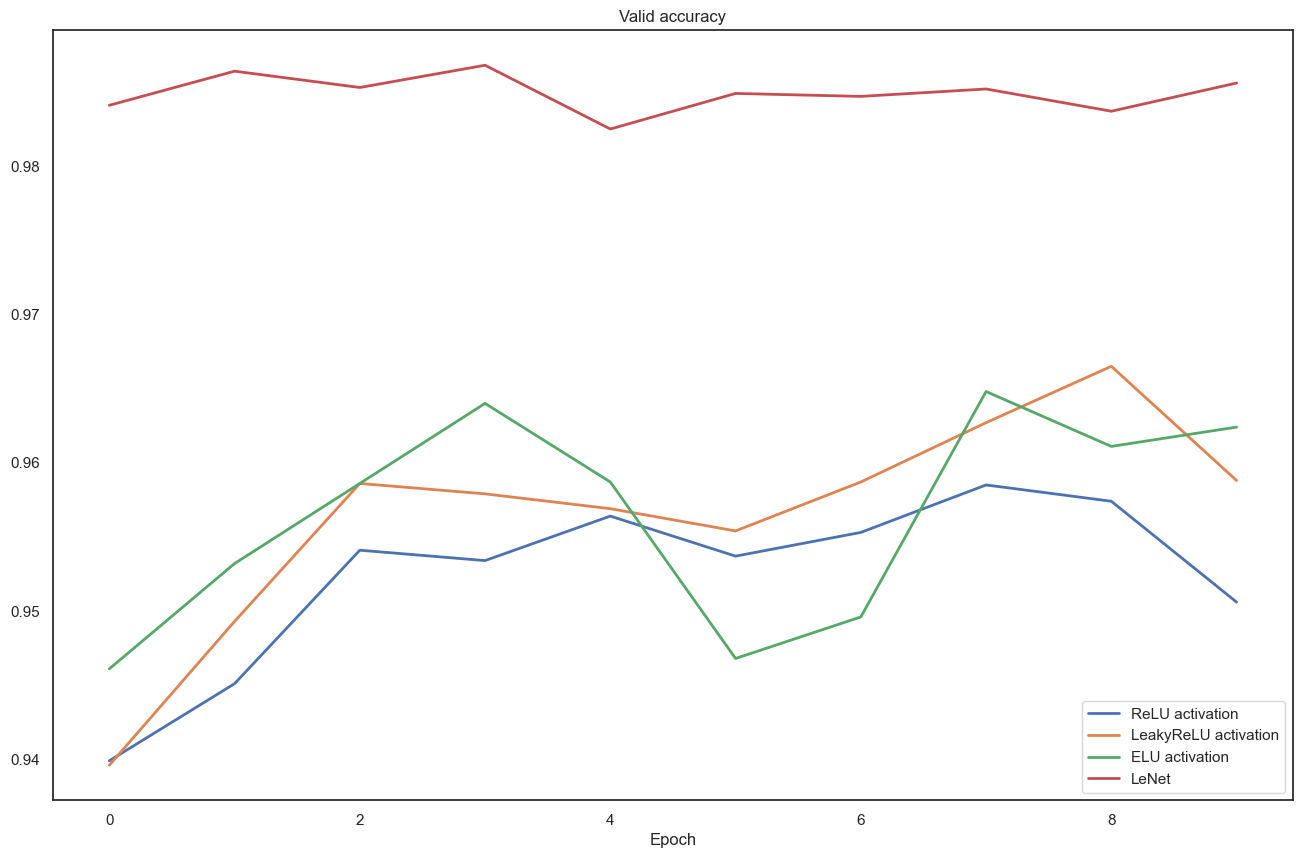

In [393]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.9856